In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # 或 ":16:8"
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
set_seed(42)

In [2]:
def f(x):
    pi = torch.pi
    return ((0.1*pi)**2 * torch.sin(0.1*pi*x) +
            (pi)**2 * 0.2 * torch.sin(pi*x) +
            (100/3*pi)**2 * 0.4 * torch.sin(100/3*pi*x) +
            (200/3*pi)**2 * 0.6 * torch.sin(200/3*pi*x) +
            (100*pi)**2 * torch.sin(100*pi*x))
def u(x):
    return torch.sin(0.1 * torch.pi * x) + \
              0.2 * torch.sin(torch.pi * x) + \
                0.4 * torch.sin(100/3 * torch.pi * x) + \
                    0.6 * torch.sin(200/3 * torch.pi * x) + \
                        torch.sin(100 * torch.pi * x)

In [8]:
class MultiScaleFourierLayer(nn.Module):
    def __init__(self, input_dim, base_feature_dim, num_scales,sigma=1.0,beta=0.1):
        super().__init__()
        self.input_dim=input_dim
        self.base_feature_dim=base_feature_dim
        self.num_scales=num_scales
        self.M = base_feature_dim * (num_scales + 1)
        base_freqs = torch.randn(self.base_feature_dim, input_dim) * np.pow(sigma,-1)
        all_freqs=[]
        for feature in base_freqs:
            for k in range(0,num_scales+1):
                scale=2.0**k
                all_freqs.append(scale*feature)
        
        omega = torch.stack(all_freqs, dim=0)

        self.register_buffer('omega',omega.reshape(-1,input_dim))
        self.total_feature_dim=self.omega.shape[0]
        print(f"Total feature dim={self.total_feature_dim}. All Fourier feature frequencies:\n{self.omega.detach().cpu().numpy().flatten()}")
        omega_np = self.omega.detach().cpu().numpy() # 形状: (M, input_dim)
        freq_magnitude = np.linalg.norm(omega_np, axis=1)
        plt.figure(figsize=(10, 6))
        plt.plot(figsize=(10, 6))
        plt.hist(freq_magnitude, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'Frequency Magnitude Distribution\nTotal Dim: {self.total_feature_dim}')
        plt.xlabel('Frequency Magnitude (L2 Norm)')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        phases=torch.rand(self.total_feature_dim)*2.0*np.pi 
        self.register_buffer('phases',phases)
        self.raw_beta=nn.Parameter(torch.log(torch.tensor(beta)))
        self.beta=nn.functional.softplus(self.raw_beta)
    def forward(self, x):
        amplitude=torch.tensor(torch.exp(- self.beta * torch.norm(self.omega,dim=1)),device=x.device)
        self.scale=torch.sqrt(torch.tensor(1.0/self.total_feature_dim))
        proj = torch.matmul(x, self.omega.T) + self.phases
        features = torch.cos(proj)
        features = features * self.scale * amplitude
        return features

In [ ]:
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_math_sdp(True)
class MLP_Network(nn.Module):
    def __init__(self,num_layers=4,width=32):
        super().__init__()
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
        layers = []
        layers.append(nn.Linear(1, width))
        for _ in range(num_layers - 2):
            layers.append(nn.Tanh())
            layers.append(nn.Linear(width, width))
        layers.append(nn.Linear(width, 1))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

class NN_CA_Network(nn.Module):
    def __init__(self, input_dim=1, base_feature_dim=64, num_scales=3,
                 d_q=64, num_layers=4, num_heads=4, sigma=0.5, beta_init=0.001):
        super().__init__()
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
        self.rff = MultiScaleFourierLayer(input_dim, base_feature_dim, num_scales, sigma, beta_init).to(self.device)
        M = self.rff.M
        self.d_q = d_q
        assert M % d_q == 0
        self.N_tok = M // d_q

        # 初始 Q^(0) 来自原始输入 x，而非φ(x)
        self.initial_fc = nn.Sequential(
            nn.Linear(input_dim, d_q),
            nn.ReLU()
        )
        # 共享相同的CA架构
        self.ca_blocks = CrossAttentionResidualBlock(d_q, num_layers, num_heads)
        self.output_layer = nn.Linear(d_q, 1)

    def forward(self, x):
        proj = torch.matmul(x, self.rff.omega.T) + self.rff.phases.unsqueeze(0)  # (B, M_post*d_q)
        scale = torch.sqrt(torch.tensor(1.0 / (self.rff.M * self.d_q), device=x.device))
        phi = torch.cos(proj) * scale
        H = phi.view(x.shape[0], self.N_tok, self.d_q)
        Q = self.initial_fc(x)  # (batch, d_q)
        Q_L = self.ca_blocks(Q, H)        
        return self.output_layer(Q_L)
    
class CrossAttentionResidualBlock(nn.Module):
    def __init__(self, d_q, num_layers, num_heads):
        super().__init__()
        assert d_q % num_heads == 0, "d_q must be divisible by num_heads"
        self.d_q = d_q
        self.num_layers = num_layers
        self.cross_attn = nn.ModuleList([
            nn.MultiheadAttention(
                embed_dim=d_q,
                num_heads=num_heads,
                dropout=0.0,
                batch_first=True,  
                bias=False
            ) for _ in range(num_layers)
        ])
        
        self.ln1 = nn.ModuleList([nn.LayerNorm(d_q) for _ in range(num_layers)])
        self.ln2 = nn.ModuleList([nn.LayerNorm(d_q) for _ in range(num_layers)])
        
        # FFN 保持不变
        self.ffns = nn.ModuleList([
            nn.Sequential(nn.Linear(d_q, d_q), nn.ReLU())
            for _ in range(num_layers)
        ])
    
    def forward(self, Q, H):
        """
        Args:
            Q: (batch, d_q) 或 (batch, 1, d_q) - Query tokens
            H: (batch, N_tokens, d_q) - Key/Value tokens (RFF features)
        """
        if Q.dim() == 2:
            Q = Q.unsqueeze(1)  # (batch, 1, d_q)
        
        for i in range(self.num_layers):
            # 内置 Cross Attention：Q 作为 query，H 作为 key/value
            # 自动完成：线性投影 → 多头分割 → 缩放 → Softmax → 拼接 → 输出投影
            attn_out, _ = self.cross_attn[i](
                query=Q,           # (batch, 1, d_q)
                key=H,             # (batch, N, d_q)  
                value=H,           # (batch, N, d_q)
                need_weights=False
            )
            
            # 残差连接 1 + LayerNorm
            Q = Q + attn_out
            Q = self.ln1[i](Q)
            
            # FFN + 残差连接 2 + LayerNorm（保持原逻辑）
            ffn_out = self.ffns[i](Q.squeeze(1)).unsqueeze(1)
            Q = Q + ffn_out
            Q = self.ln2[i](Q)
        
        return Q.squeeze(1)

class OneDimPoissonFunc(nn.Module):
    """
    神经网络求解器的抽象类
    """
    def __init__(self,batch_size=64,alpha=None):
        super().__init__()
        self.alpha=alpha
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.record_steps=250
        self.lb = -1.0
        self.ub = 1.0
        self.boundary_x = torch.tensor([[-1.0], [1.0]], device=self.device)
        self.boundary_u = torch.tensor([[u(torch.tensor(-1.0))], [u(torch.tensor(1.0))]],device=self.device)
        self.batch_size = batch_size
        self.x_eval = torch.linspace(self.lb, self.ub, 2048).reshape(-1, 1)
        self.u_eval = u(self.x_eval)
        self.lb = torch.tensor(self.lb).to(self.device)
        self.ub = torch.tensor(self.ub).to(self.device)
        #----------------------------------------------------------------------------------
        self.u_h=NN_CA_Network(input_dim=1, base_feature_dim=4096, num_scales=0,
                          d_q=512, num_layers=2, num_heads=4, sigma=0.006).to(self.device)
        #----------------------------------------------------------------------------------
        self.u_l=MLP_Network(num_layers=5,width=64).to(self.device)
        self.alpha_para = nn.Parameter(torch.tensor(1.0,device=self.device))
        self.optimizer_h = torch.optim.AdamW([
            {
                'params': self.u_h.parameters(),
                'lr': 1e-2,
                "weight_decay": 1e-4
            }
        ])
        self.optimizer_l = torch.optim.Adam([
            {
                'params': self.u_l.parameters(),
                'lr':100.0,
            }
        ])
        self.optimizer_alpha = torch.optim.Adam([self.alpha_para], lr=1e-3)

        self.scheduler_h = torch.optim.lr_scheduler.ReduceLROnPlateau(
        self.optimizer_h, 
        mode='min',         
        factor=0.9,          
        patience=50,       
        )
        self.scheduler_l= torch.optim.lr_scheduler.LambdaLR(self.optimizer_l, lr_lambda=lambda epoch: self.schedule(epoch, warmup_epochs=1000))
        self.lam = 1e6
        self.history = {'alpha': [], 'loss': [], 'error': []}
    
    def schedule(self, epoch, warmup_epochs):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        else:
            return 1.0
        
    def net_u(self, x):
        return self.get_alpha() * self.u_l(x) + self.u_h(x)

    def get_alpha(self):
        """mode 取 0, 1, "opt" 或者 learnable """
        if self.alpha == 0:
            return 0.0
        if self.alpha == 1:
            return 1.0
        if self.alpha == "opt":
            x_r = torch.linspace(self.lb, self.ub, 256).view(-1, 1).to(self.device).requires_grad_()
            x_b = torch.tensor(self.boundary_x).view(-1, 1).to(self.device)
            N_uh = self.diff_operator(x_r, self.u_h).detach()  # N[u_h] = -u_h''
            N_ul = self.diff_operator(x_r, self.u_l).detach()  # N[u_l] = -u_l''
            with torch.no_grad():
                f_xr = f(x_r)
                # 分子: mean((N[u_h] - f) * N[u_l])
                numerator = torch.mean((N_uh - f_xr) * N_ul)
                # 分母: mean(N[u_l]^2) + lam * mean(u_l^2 on boundary)
                u_l_boundary = self.u_l(x_b)
                denominator = torch.mean(N_ul**2) + torch.mean(u_l_boundary**2)
                            
            if abs(denominator.item()) < 1e-10:
                return 0.0
            return - (numerator / denominator).item()
        
        if self.alpha =="learnable":
            return self.alpha_para
        
    def diff_operator(self, x, model):
        """计算PDE残差: -u'' = f -> u'' + f = 0"""
        u = model(x)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        return - u_xx 

    def loss(self):
        x_f = torch.rand(self.batch_size, 1, device=self.device)  # [0, 1)
        x_f = (self.lb + (self.ub - self.lb) * x_f).requires_grad_() 
        alpha = self.get_alpha()
        loss_f = torch.mean((self.diff_operator(x_f,self.u_h)+alpha*self.diff_operator(x_f,self.u_l)-f(x_f))**2)
        loss_b = self.lam * torch.mean((self.u_h(self.boundary_x)-self.boundary_u)**2+self.u_l(self.boundary_x)**2)
        if isinstance(alpha, torch.Tensor):
            alpha = alpha.detach().cpu().item()
        else:
            alpha = alpha
        self.history['alpha'].append(alpha)
        return loss_f,loss_b,alpha
    
    def fit(self, nIter):
        self.train()
        for i in range(nIter):
            # 计算损失 
            loss_f,loss_b,alpha = self.loss()
            u_h_lr = self.optimizer_h.param_groups[0]['lr']
            if i %100 == 0:
                print(f'Iter {i} |Loss_f: {loss_f.item():.3e},Loss_b:{loss_b.item():.3e},Alpha: {alpha:.3f}, u_h_lr: {u_h_lr:.3e}')
            # 单步反向传播和更新
            loss = loss_f + loss_b
            self.optimizer_h.zero_grad()
            self.optimizer_l.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(self.u_h.parameters()), max_norm=1.0)
            self.scheduler_l.step(loss)
            self.scheduler_h.step(loss)
            self.optimizer_h.step() 
            self.optimizer_l.step()
            self.optimizer_alpha.step()
            # 计算相对误差 
            self.history['loss'].append(loss.item())
            if i % self.record_steps == 0:
                self.eval()
                x_eval_tensor = torch.tensor(self.x_eval).to(self.device)
                u_pred = self.predict(x_eval_tensor)
                error = np.linalg.norm(u_pred -self.u_eval.detach().cpu().numpy()) / np.linalg.norm(self.u_eval.detach().cpu().numpy())
                self.history['error'].append(error)
                print(f'Iter {i+1}/{nIter} | Relative Error: {error:.3e}')
                self.train()
            
        self.plot()
        return self.history
        
    def predict(self, x):
        """预测结果"""
        x_tensor = torch.tensor(x).to(self.device)
        alpha = self.get_alpha()
        with torch.no_grad():
            u_pred = alpha * self.u_l(x_tensor) + self.u_h(x_tensor)
        return u_pred.cpu().numpy() 
    
    def plot(self):
        """绘制预测结果和相对误差历史"""
        # 1. 绘制 loss 和 relative L2 error 曲线
        if self.alpha == 0:
            label = '$\\alpha=0$'
            line = 'b-'
        elif self.alpha == 1:
            label = '$\\alpha=1$'
            line = 'o-'
        elif self.alpha == "opt":
            label = 'optimial $\\alpha$'
            line = 'r-'
        elif self.alpha == "learnable":
            label = 'learnable $\\alpha$'
            line = 'g-'
        plt.figure(figsize=(16,9))
        plt.subplot(2, 2, 2)
        epochs = range(0, len(self.history['error'])*self.record_steps, self.record_steps)
        plt.semilogy(epochs, self.history['error'], line, linewidth=1,label=label)
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.title('Relative Error History')
        plt.grid(True, which="both", ls="-", alpha=0.3)
        plt.legend()
        
        plt.subplot(2,2,1)
        plt.semilogy(range(len(self.history['loss'])), self.history['loss'], line, linewidth=1, label=label)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 2, 4)
        alpha_epochs = range(len(self.history['alpha']))
        plt.plot(alpha_epochs, self.history['alpha'], line, linewidth=1, label=label)
        plt.title('Alpha Evolution')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        
        plt.subplot(2, 2, 3)
        residual = self.predict(self.x_eval) - self.u_eval.detach().cpu().numpy()
        plt.plot(self.x_eval, residual, line, linewidth=1, label=label)
        plt.xlabel('x')
        plt.ylabel('Residual')
        plt.title('Pointwise Residual')
        plt.legend()
        plt.grid(True)
        plt.xlim(-1, 1)
        plt.show()

        # 2. 绘制真实解与预测解对比
        u_pred = self.predict(self.x_eval)
        plt.figure(figsize=(12, 5))
        plt.plot(self.x_eval, self.u_eval, 'k--', linewidth=2, label='Truth')
        plt.plot(self.x_eval, u_pred, 'r-', linewidth=2, label='Pred')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.title('True vs Predicted Solution')
        plt.legend()
        plt.grid(True)
        plt.xlim(-1, 1)
        plt.show()
        if self.alpha == "learnable":
            alpha = self.get_alpha().item()  # 获取最终 alpha
        else:
            alpha = self.get_alpha()
        with torch.no_grad():
            u_h_pred = self.u_h(torch.tensor(self.x_eval).to(self.device)).cpu().numpy()
            u_l_pred = self.u_l(torch.tensor(self.x_eval).to(self.device)).cpu().numpy()
            alpha_u_l = alpha * u_l_pred

        plt.figure(figsize=(12, 5))
        plt.plot(self.x_eval, u_h_pred, 'b-', linewidth=2, label='$u_h$')
        plt.plot(self.x_eval, alpha_u_l, 'g-', linewidth=2, label='$\\alpha u_l$')
        plt.xlabel('x') 
        plt.ylabel('Component')
        plt.title('High-Frequency and Low-Frequency Components')
        plt.legend()
        plt.grid(True)
        plt.xlim(-1, 1)
        plt.show()


In [5]:
def plot_comparison(models, histories):
    """
    models: 包含4个 OneDimPoissonFunc 实例的列表
    histories: 包含4个对应的 history 字典的列表
    """
    plt.figure(figsize=(16, 9))
    
    # 定义颜色和标签映射
    configs = [
        {'val': 0, 'color': 'b-', 'label': r'$\alpha=0$'},
        {'val': 1, 'color': 'c-', 'label': r'$\alpha=1$'}, # 用不同颜色区分
        {'val': "opt", 'color': 'r-', 'label': 'optimal $\\alpha$'},
        {'val': "learnable", 'color': 'g-', 'label': 'learnable $\\alpha$'}
    ]

    # --- 子图 1: Loss History ---
    plt.subplot(2, 2, 1)
    for i, h in enumerate(histories):
        cfg = configs[i]
        plt.semilogy(range(len(h['loss'])), h['loss'], cfg['color'], linewidth=1.5, label=cfg['label'])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.legend()

    # --- 子图 2: Relative Error History ---
    plt.subplot(2, 2, 2)
    for i, h in enumerate(histories):
        cfg = configs[i]
        # 注意：history['error'] 是每隔 record_steps 记录一次
        epochs = range(0, len(h['error']) * models[0].record_steps, models[0].record_steps)
        plt.semilogy(epochs, h['error'], cfg['color'], linewidth=1.5, label=cfg['label'])
    plt.xlabel('Iteration')
    plt.ylabel('Relative L2 Error')
    plt.title('Relative Error History')
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.legend()

    # --- 子图 3: Alpha Evolution ---
    plt.subplot(2, 2, 4) # 放在右下角，视觉平衡
    for i, h in enumerate(histories):
        cfg = configs[i]
        plt.plot(range(len(h['alpha'])), h['alpha'], cfg['color'], linewidth=1.5, label=cfg['label'])
    plt.xlabel('Iteration')
    plt.ylabel('Alpha Value')
    plt.title('Alpha Evolution')
    plt.grid(True)
    plt.legend()

    # --- 子图 4: Pointwise Residual ---
    plt.subplot(2, 2, 3) # 放在左下角
    x_eval_numpy = models[0].x_eval.cpu().numpy() # 假设所有模型的 x_eval 一样
    u_eval_numpy = models[0].u_eval.detach().cpu().numpy()
    
    for i, model in enumerate(models):
        cfg = configs[i]
        u_pred = model.predict(x_eval_numpy) # 使用模型的 predict 方法
        residual = u_pred - u_eval_numpy
        plt.plot(x_eval_numpy, residual, cfg['color'], linewidth=1.5, label=cfg['label'])
    
    plt.xlabel('x')
    plt.ylabel('Residual (u_pred - u_true)')
    plt.title('Pointwise Residual')
    plt.legend()
    plt.grid(True)
    plt.xlim(-1, 1)
    
    plt.tight_layout()
    plt.show()

Initializing models...
Total feature dim=4096. All Fourier feature frequencies:
[321.15256   247.88069   150.11954   ... -23.385489  156.93658
  -1.9738128]


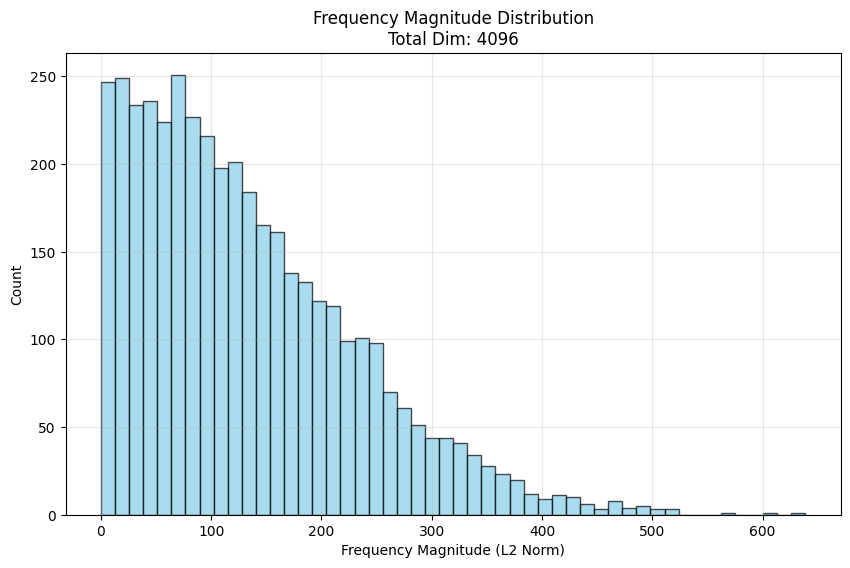

Total feature dim=4096. All Fourier feature frequencies:
[ 165.14554   -36.097073 -439.64313  ...  -22.083792   72.81252
  371.39154 ]


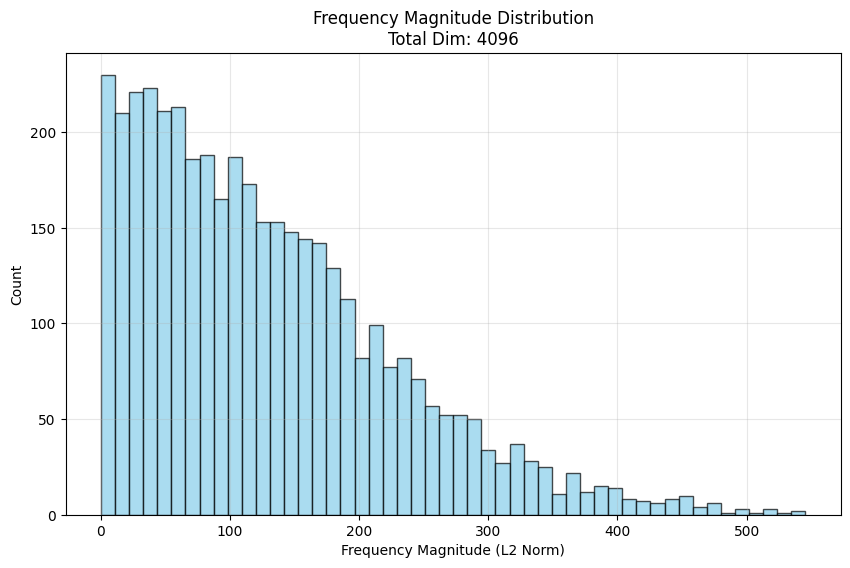

Total feature dim=4096. All Fourier feature frequencies:
[-270.53705   185.99666  -227.03932  ...   17.282719 -142.61404
   91.87138 ]


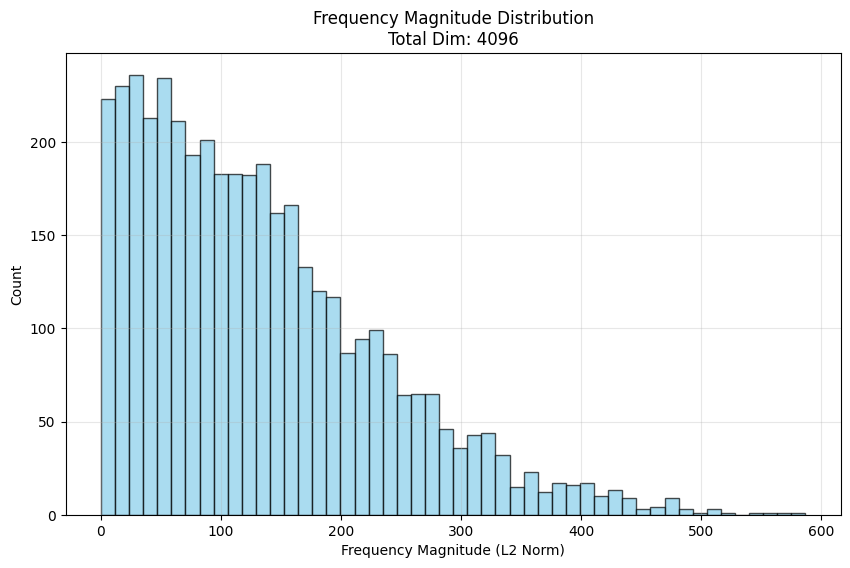

Total feature dim=4096. All Fourier feature frequencies:
[ -97.7794    162.92868   180.02612  ... -162.07532    12.30019
  -17.077187]


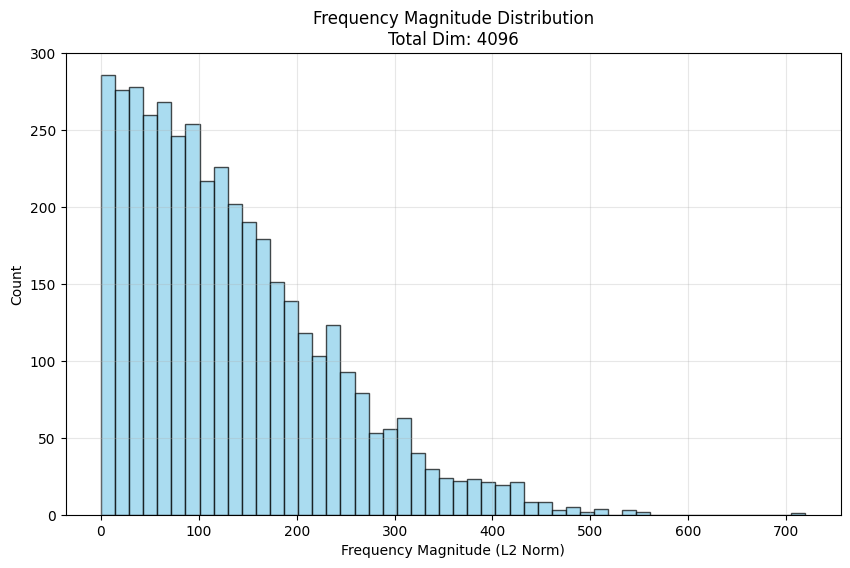

Starting training...

=== Training model with alpha=0 ===
Iter 0 |Loss_f: 5.241e+09,Loss_b:1.552e+06,Alpha: 0.000, u_h_lr: 1.000e-02


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:204: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/py

Iter 1/10 | Relative Error: 5.685e+00


KeyboardInterrupt: 

In [6]:
# 1. 实例化 4 个不同配置的模型
# 注意：确保 MultiScaleFourierLayer, f(x), u(x) 等已在代码上方定义

print("Initializing models...")
model_0 = OneDimPoissonFunc(alpha=0)
model_1 = OneDimPoissonFunc(alpha=1)
model_opt = OneDimPoissonFunc(alpha="opt")
model_learn = OneDimPoissonFunc(alpha="learnable")

models = [model_0, model_1, model_opt, model_learn]
histories = []

# 2. 训练所有模型
print("Starting training...")
for m in models:
    print(f"\n=== Training model with alpha={m.alpha} ===")
    h = m.fit(10)
    histories.append(h)

# 3. 绘制组合图
print("\nPlotting comparison...")
plot_comparison(models, histories)

Total feature dim=4096. All Fourier feature frequencies:
[321.15256   247.88069   150.11954   ... -23.385489  156.93658
  -1.9738128]


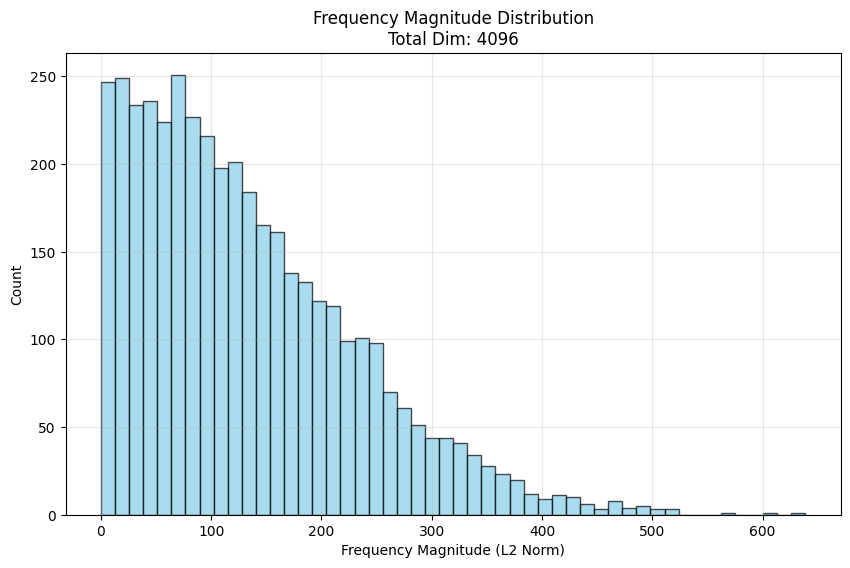

C:\Users\hp\AppData\Local\Temp\ipykernel_7264\2017310408.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_b = torch.tensor(self.boundary_x).view(-1, 1).to(self.device)


Iter 0 |Loss_f: 5.944e+09,Loss_b:2.163e+05,Alpha: -12.259, u_h_lr: 1.000e-02


C:\Users\hp\AppData\Local\Temp\ipykernel_7264\2017310408.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_eval_tensor = torch.tensor(self.x_eval).to(self.device)
C:\Users\hp\AppData\Local\Temp\ipykernel_7264\2017310408.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x).to(self.device)


Iter 1/100 | Relative Error: 7.858e+00


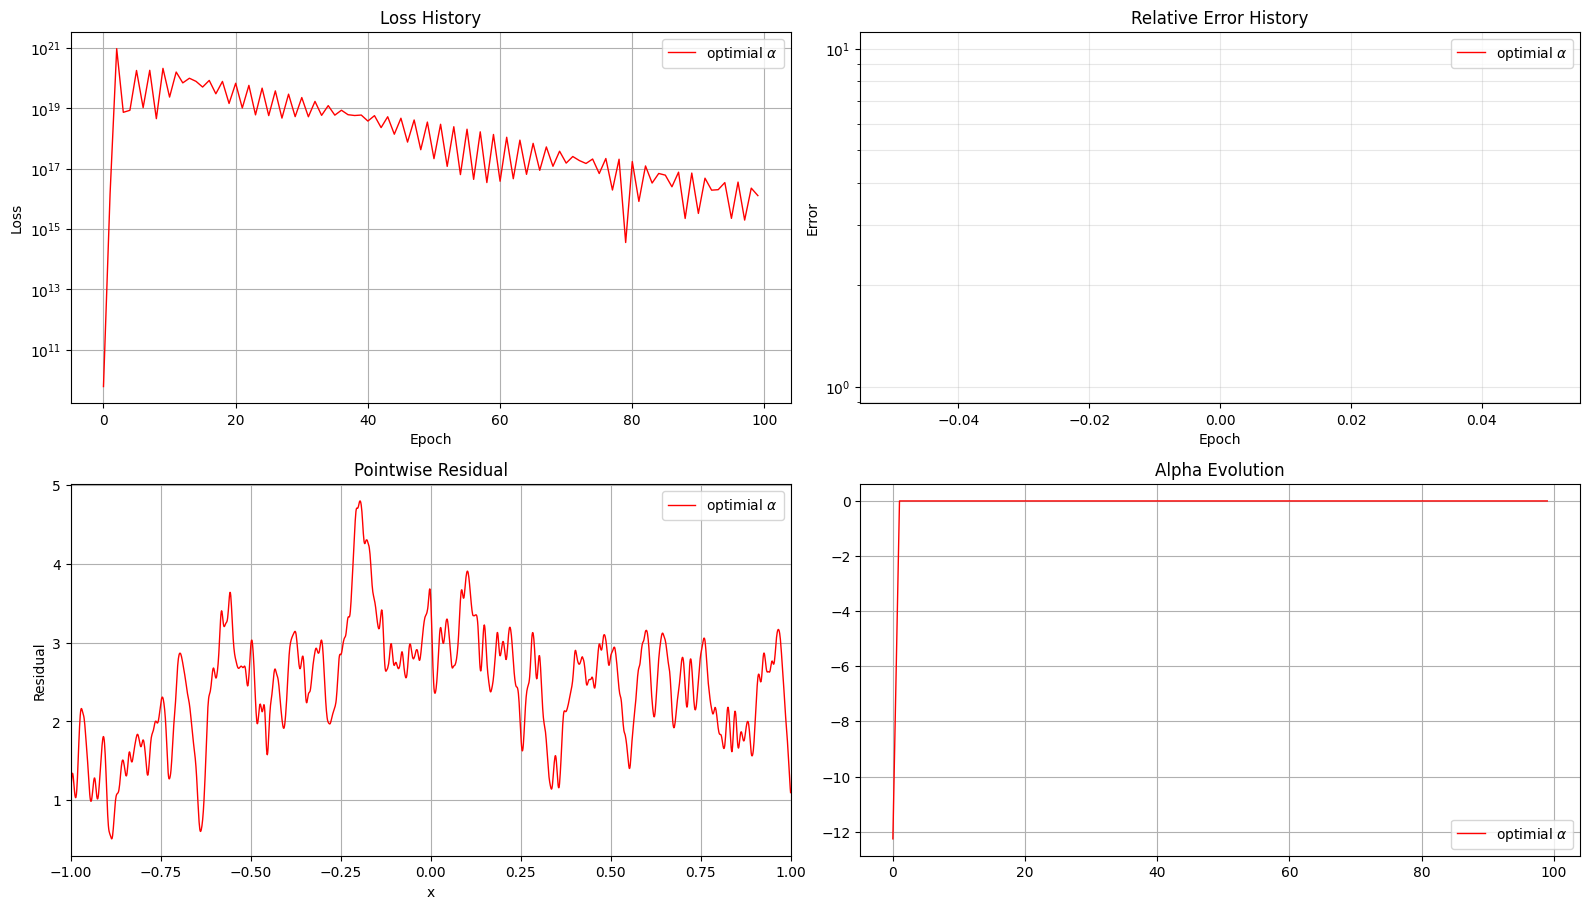

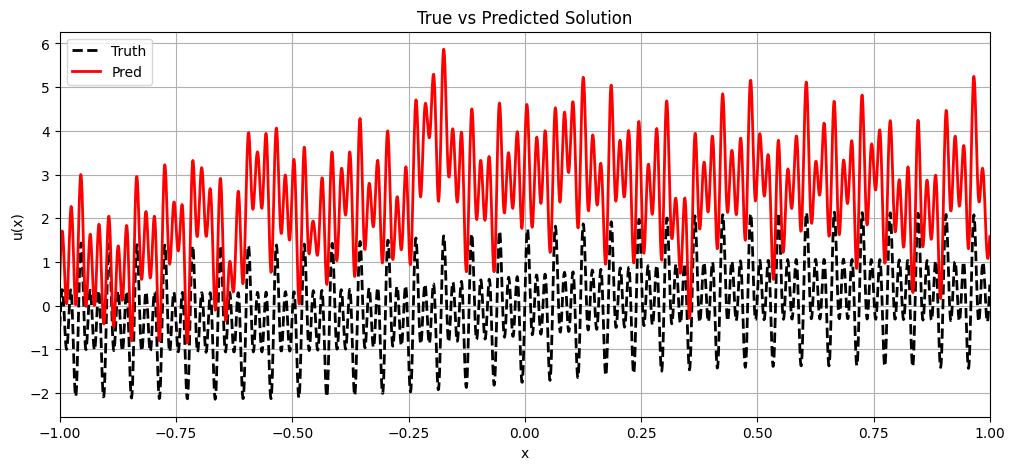

C:\Users\hp\AppData\Local\Temp\ipykernel_7264\2017310408.py:315: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_h_pred = self.u_h(torch.tensor(self.x_eval).to(self.device)).cpu().numpy()
C:\Users\hp\AppData\Local\Temp\ipykernel_7264\2017310408.py:316: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_l_pred = self.u_l(torch.tensor(self.x_eval).to(self.device)).cpu().numpy()


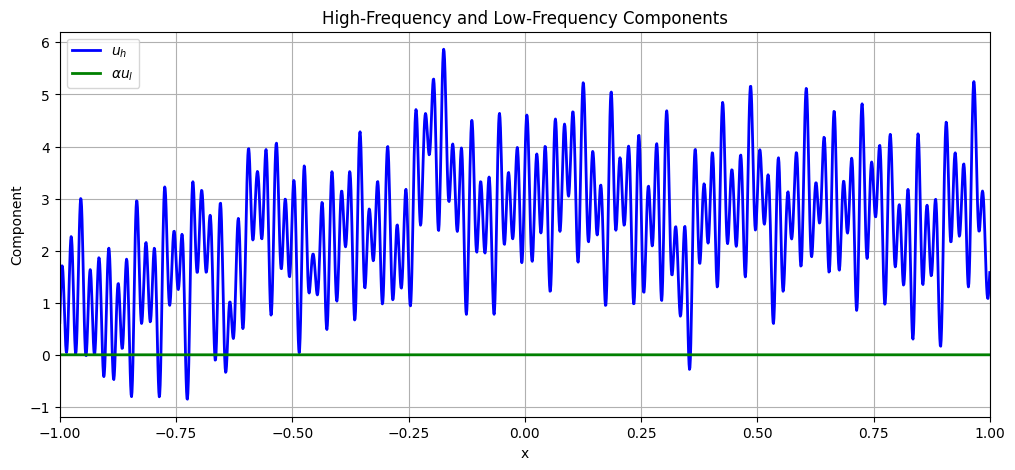

In [11]:
set_seed(42)
one_dim_poisson_func=OneDimPoissonFunc()
one_dim_poisson_func.alpha="opt"
opt_history=one_dim_poisson_func.fit(100)